# Code for data preparation

-	**Kuramoto_simulation:**
	- Input: (number of nodes, coupling, number of timesteps)
	- Output: multivariate timeseries as pandas dataframe
-	**Perceptron_simulation:**
	- Input: ? (systemsize, learningrate and time)
	- Output: multivariate timeseries as pandas dataframe
-	**Human_connectome_data:**
	- Input: desired HCP data folder
	- Output: multivariate timeseries as pandas dataframe


# Kuramoto modelling

Import libraries

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import xgi
import pandas as pd
import os

Define functions

In [81]:
# === Traditional Kuramoto ===
def kuramoto_traditional(t, theta, omega, K, N):
    theta_i = theta[:, np.newaxis]
    theta_j = theta[np.newaxis, :]
    coupling_sum = np.sum(np.sin(theta_j - theta_i), axis=1)
    return omega + (K / N) * coupling_sum

def simulate_traditional_time_series(N, K, T=10, dt=0.01, n_sim=4):
    t_eval = np.arange(0, T, dt)
    r_all = []
    freq_dfs = []

    for _ in range(n_sim):
        omega = np.random.normal(0, 1, N)
        theta0 = np.random.uniform(0, 2*np.pi, N)

        sol = solve_ivp(kuramoto_traditional, [0, T], theta0, t_eval=t_eval, args=(omega, K, N))
        theta_ts = sol.y.T

        # Instantaneous frequencies
        freqs = np.gradient(theta_ts, axis=0) / dt

        # Store as DataFrame
        freq_df = pd.DataFrame(freqs, index=t_eval, columns=[f"osc_{i}" for i in range(N)])
        freq_dfs.append(freq_df)

        # Order parameter r(t)
        r = np.abs(np.mean(np.exp(1j * theta_ts), axis=1))
        r_all.append(r)

    r_all = np.array(r_all)
    return t_eval, r_all, freq_dfs 

def simulate_traditional_r_vs_K(N, K_vals, T=20, dt=0.01, n_sim=4):
    all_r = []

    for sim in range(n_sim):
        r_per_sim = []
        for K in K_vals:
            omega = np.random.normal(0, 1, N)
            theta = np.random.uniform(0, 2*np.pi, N)
            t_eval = np.arange(0, T, dt)
            sol = solve_ivp(kuramoto_traditional, [0, T], theta, t_eval=t_eval, args=(omega, K, N))
            r = np.abs(np.mean(np.exp(1j * sol.y.T), axis=1))
            r_per_sim.append(np.mean(r[int(0.5 * len(r)):]))

        all_r.append(r_per_sim)

    all_r = np.array(all_r)
    mean_r = np.mean(all_r, axis=0)
    return all_r, mean_r

# === XGI Kuramoto ===
def kuramoto_xgi(t, theta, omega, K2, K3, H, N):
    H_int = xgi.convert_labels_to_integers(H, "label")
    links = H_int.edges.filterby("size", 2).members()
    triangles = H_int.edges.filterby("size", 3).members()
    dtheta = np.zeros(N)
    r1 = np.zeros(N, dtype=complex)
    r2 = np.zeros(N, dtype=complex)
    for i, j in links:
        r1[i] += np.exp(1j * theta[j])
        r1[j] += np.exp(1j * theta[i])
    for i, j, k in triangles:
        r2[i] += np.exp(2j * theta[j] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[j])
        r2[j] += np.exp(2j * theta[i] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[i])
        r2[k] += np.exp(2j * theta[i] - 1j * theta[j]) + np.exp(2j * theta[j] - 1j * theta[i])
    for i in range(N):
        dtheta[i] = omega[i] + K2 * np.imag(r1[i] * np.exp(-1j * theta[i])) + K3 * np.imag(r2[i] * np.exp(-1j * theta[i]))
    return dtheta

def simulate_xgi_time_series(N, K, T=10, dt=0.01, n_sim=4):
    # generate fully connected hypergraph of N nodes
    H = xgi.Hypergraph()
    nodes = list(range(N))
    H.add_nodes_from(nodes)
    max_order = 3
    
    for k in range(1, max_order + 1):
        for edge in itertools.combinations(nodes, k):
            H.add_edge(edge)
    
    t_eval = np.arange(0, T, dt)
    K2 = K / N
    K3 = 0  # Adjust if high order included

    r_all = []
    freq_dfs = []

    for _ in range(n_sim):
        omega = np.random.normal(0, 1, N)
        theta0 = np.random.uniform(0, 2*np.pi, N)

        sol = solve_ivp(kuramoto_xgi, [0, T], theta0, t_eval=t_eval, args=(omega, K2, K3, H, N))
        theta_ts = sol.y.T

        # Instantaneous frequencies
        freqs = np.gradient(theta_ts, axis=0) / dt
        freq_df = pd.DataFrame(freqs, index=t_eval, columns=[f"osc_{i}" for i in range(N)])
        freq_dfs.append(freq_df)

        # Order parameter
        r = np.abs(np.mean(np.exp(1j * theta_ts), axis=1))
        r_all.append(r)

    r_all = np.array(r_all)
    return t_eval, r_all, freq_dfs

def simulate_xgi_r_vs_K(N, K_vals, T=20, dt=0.01, n_sim=4):
    all_r = []

    for sim in range(n_sim):
        r_per_sim = []
        for K in K_vals:
            H = xgi.Hypergraph()
            H.add_nodes_from(range(N))
            for i in range(N):
                for j in range(i + 1, N):
                    H.add_edge([i, j])

            K2 = K / N
            K3 = 0
            omega = np.random.normal(0, 1, N)
            theta = np.random.uniform(0, 2*np.pi, N)
            timesteps = int(T / dt)
            theta_time = np.zeros((timesteps, N))
            theta_curr = theta.copy()
            links = H.edges.filterby("size", 2).members()
            triangles = H.edges.filterby("size", 3).members()

            for t in range(timesteps):
                theta_time[t] = theta_curr
                r1 = np.zeros(N, dtype=complex)
                r2 = np.zeros(N, dtype=complex)
                for i, j in links:
                    r1[i] += np.exp(1j * theta_curr[j])
                    r1[j] += np.exp(1j * theta_curr[i])
                for i, j, k in triangles:
                    r2[i] += np.exp(2j * theta_curr[j] - 1j * theta_curr[k]) + np.exp(2j * theta_curr[k] - 1j * theta_curr[j])
                    r2[j] += np.exp(2j * theta_curr[i] - 1j * theta_curr[k]) + np.exp(2j * theta_curr[k] - 1j * theta_curr[i])
                    r2[k] += np.exp(2j * theta_curr[i] - 1j * theta_curr[j]) + np.exp(2j * theta_curr[j] - 1j * theta_curr[i])
                dtheta = omega + K2 * np.imag(r1 * np.exp(-1j * theta_curr)) + K3 * np.imag(r2 * np.exp(-1j * theta_curr))
                theta_curr += dtheta * dt

            r = np.abs(np.mean(np.exp(1j * theta_time), axis=1))
            r_per_sim.append(np.mean(r[int(0.5 * len(r)):]))

        all_r.append(r_per_sim)

    all_r = np.array(all_r)
    mean_r = np.mean(all_r, axis=0)
    return all_r, mean_r

Plot the characteristic coupling regions

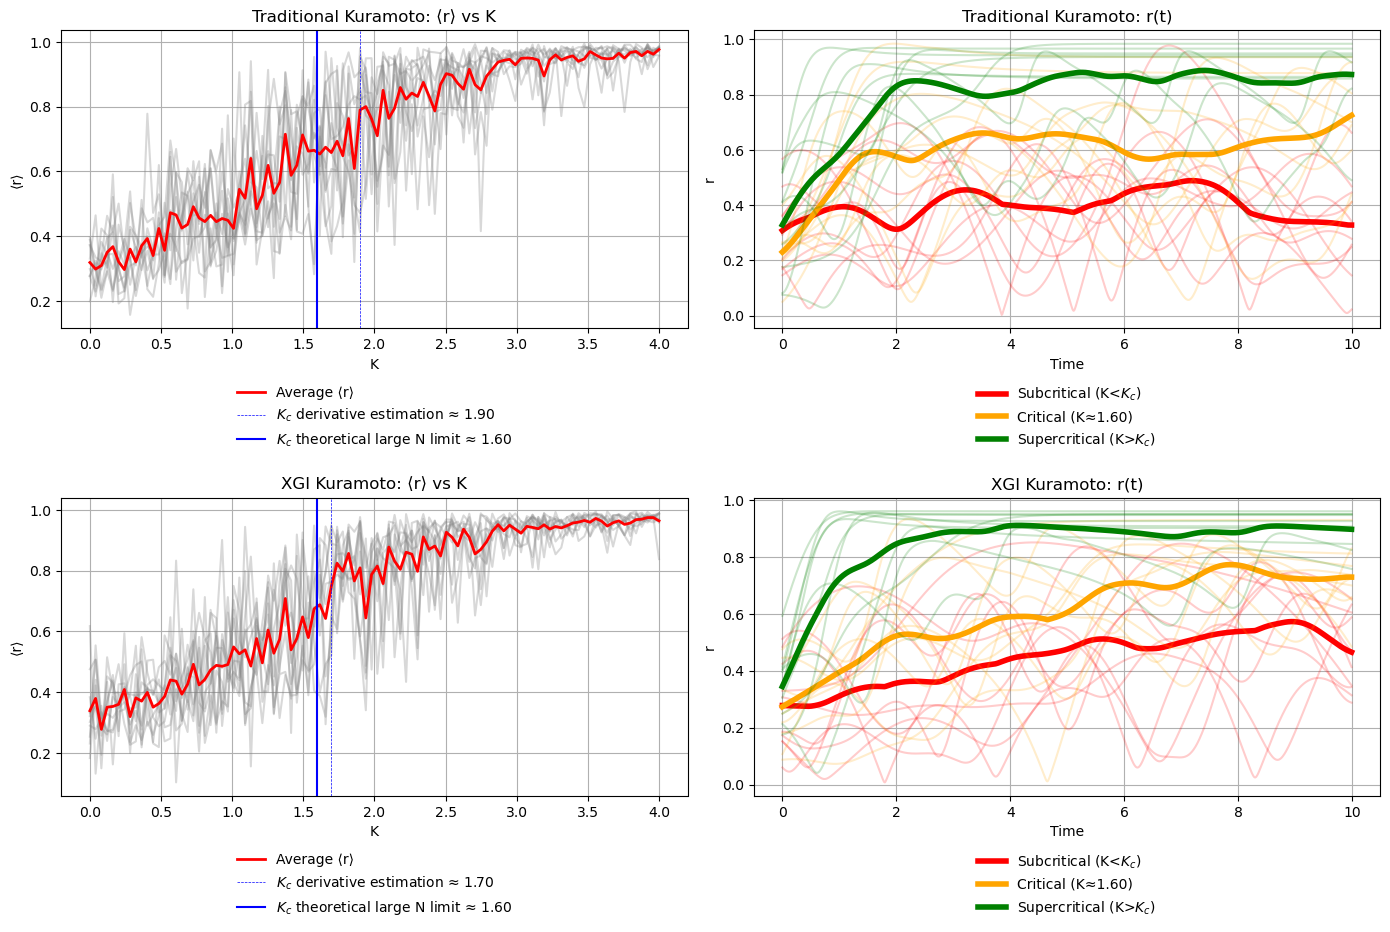

In [91]:
# === Plotting ===
n_simulations = 10
N = 8
T = 10
dt = 0.01
Kc_theoretical = 1.5958    # Theoretical estimation of critical coupling in the large N limit
K_vals = np.linspace(0, 4, 100)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Traditional: r vs K
all_r_trad, mean_r_trad = simulate_traditional_r_vs_K(N, K_vals, T, dt, n_simulations)
r_diff_trad = np.gradient(mean_r_trad, K_vals)
Kc_trad = K_vals[np.argmax(r_diff_trad)]

# Traditional: set the conditions for coupling regions
Ks_to_plot = [Kc_theoretical-1, Kc_theoretical, Kc_theoretical+1]
colors = ['r', 'orange', 'green']
labels = [f'Subcritical (K<$K_c$)', f'Critical (K≈{Kc_theoretical:.2f})', 'Supercritical (K>$K_c$)']

# Traditional: r vs K plot
for sim_r in all_r_trad:
    axs[0, 0].plot(K_vals, sim_r, color='gray', alpha=0.3)
axs[0, 0].plot(K_vals, mean_r_trad, color='red', linewidth=2, label='Average ⟨r⟩')
axs[0, 0].axvline(Kc_trad, color='blue', linestyle='--', linewidth=0.5, label=f'$K_c$ derivative estimation ≈ {Kc_trad:.2f}')
axs[0, 0].axvline(Kc_theoretical, color='blue', linestyle='-', label=f'$K_c$ theoretical large N limit ≈ {Kc_theoretical:.2f}')
axs[0, 0].set_title('Traditional Kuramoto: ⟨r⟩ vs K')
axs[0, 0].set_xlabel('K')
axs[0, 0].set_ylabel('⟨r⟩')
axs[0, 0].grid(True)
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# Traditional: Time series
for K, label, color in zip(Ks_to_plot, labels, colors):
    t, r_all, frequencies = simulate_traditional_time_series(N, K, T, dt, n_simulations)
    for run in r_all:
        axs[0, 1].plot(t, run, color=color, alpha=0.2)
    axs[0, 1].plot(t, r_all.mean(axis=0), color=color, linewidth=4, label=label)
axs[0, 1].set_title('Traditional Kuramoto: r(t)')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('r')
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# XGI: r vs K
all_r_xgi, mean_r_xgi = simulate_xgi_r_vs_K(N, K_vals, T, dt, n_simulations)
r_diff_xgi = np.gradient(mean_r_xgi, K_vals)
Kc_xgi = K_vals[np.argmax(r_diff_xgi)]

# XGI: set the conditions for coupling regions
Ks_to_plot = [Kc_theoretical-1, Kc_theoretical, Kc_theoretical+1]
colors = ['r', 'orange', 'green']
labels = ['Subcritical (K<$K_c$)', f'Critical (K≈{Kc_theoretical:.2f})', 'Supercritical (K>$K_c$)']

# XGI: r vs K plot
for sim_r in all_r_xgi:
    axs[1, 0].plot(K_vals, sim_r, color='gray', alpha=0.3)
axs[1, 0].plot(K_vals, mean_r_xgi, color='red', linewidth=2, label='Average ⟨r⟩')
axs[1, 0].axvline(Kc_xgi, color='blue', linestyle='--', linewidth=0.5, label=f'$K_c$ derivative estimation ≈ {Kc_xgi:.2f}')
axs[1, 0].axvline(Kc_theoretical, color='blue', linestyle='-', label=f'$K_c$ theoretical large N limit ≈ {Kc_theoretical:.2f}')
axs[1, 0].set_title('XGI Kuramoto: ⟨r⟩ vs K')
axs[1, 0].set_xlabel('K')
axs[1, 0].set_ylabel('⟨r⟩')
axs[1, 0].grid(True)
axs[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# XGI: Time series
for K, label, color in zip(Ks_to_plot, labels, colors):
    t, r_all, frequencies = simulate_xgi_time_series(N, K, T, dt, n_simulations)
    for run in r_all:
        axs[1, 1].plot(t, run, color=color, alpha=0.2)
    axs[1, 1].plot(t, r_all.mean(axis=0), color=color, linewidth=4, label=label)
axs[1, 1].set_title('XGI Kuramoto: r(t)')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('r')
axs[1, 1].grid(True)
axs[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

Generate and store timeseries data

In [ ]:
# Choose model
model = "traditional"  # or "XGI"

# Parameters
N = 8       # Number of oscillators
K = 3.0     # Coupling strength
T = 20      # Total time
dt = 0.01   # Time step
n_sim = 3  # Number of simulations

# Set K2 = K / N for consistency with the standard Kuramoto model
K2 = K / N
K3 = 0  # Higher-order interactions

# Run the simulation
if model == "traditional":
    t, r_vals, freqs = simulate_traditional_time_series(N, K, T, dt, n_sim)
elif model == "XGI":
    t, r_vals, freqs = simulate_xgi_time_series(N, K, T, dt, n_sim)
else:
    raise ValueError(f"Unknown model type: {model}")

# Ensure output directory exists
output_dir = f'Data/Kuramoto_data/{model}'
os.makedirs(output_dir, exist_ok=True)

# Save each frequency time series to CSV
for i in range(len(freqs)):
    freqs[i].to_csv(f'{output_dir}/kuramoto_frequencies_timeseries_N{N}_K{K}_T{T}_{i+1}.csv', index=False)